# The LSTM (Double) Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [2]:
# import data
df = pd.read_csv("WorldCases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
# countries we are interested in
countries = ["Japan", "Canada", "Brazil", "Argentina", "Singapore", "Italy", "The United Kingdom"]
df1 = df[countries]
df1.insert(0, "date", df["date"])
df = df1
df

,date,Japan,Canada,Brazil,Argentina,Singapore,Italy,The United Kingdom
0,2020-02-01,1,1,0,0,3,0,1
1,2020-02-02,2,0,0,0,2,0,0
2,2020-02-03,5,0,0,0,0,0,0
3,2020-02-04,0,4,0,0,0,0,1
4,2020-02-05,3,1,0,0,6,0,18
...,...,...,...,...,...,...,...,...
943,2022-09-01,167340,0,16806,0,2154,21814,5225
944,2022-09-02,153313,0,15842,0,2044,20498,4616
945,2022-09-03,135425,21303,14821,0,1948,19158,4350
946,2022-09-04,117130,0,11471,11636,1549,17660,3808


# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [3]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each country
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for country in countries:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[country].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[country] = temp

In [4]:
df1.set_index("date", inplace=True)

In [5]:
# input: original dataset, country we want
# output: all data, sorted by date, of that country
def extract(dataset, country):
    # select data only from the input country
    temp = dataset.to_dict()[country]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

# Data Preprocessing
## Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [6]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

## Scaling
- Scale the data to [-1,1]

In [7]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

## Reshaping

In [8]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# transform series into train and test sets for supervised learning
def prepare_data(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for train_scaled, test_scaled
    train_scaled = [row[0][0] for row in train_scaled]
    test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = series_to_supervised(train_scaled, n_lag, n_seq).values
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list of np array, train: np array, test: np array

# Long Short-Term Memory(LSTM)
- The Long Short-Term Memory network or LSTM is a recurrent neural network that can learn and forecast long sequences.
- Walk forward model validation: a prediction will be made for a time step, then the real value used for model to predict next time step
    - stimulates the reality
- RMSE will be used: punishes large errors and results in a score that is in the same units as the forecast data

In [9]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = keras.Sequential()
    # two layers of lstm
    model.add(layers.LSTM(n_neurons, return_sequences=True, 
                          batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[2], X.shape[2]), stateful=True))
    model.add(layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Prediction and Evaluation

In [10]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]][0]
# evaluate the model
def make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [11]:
# evaluate forcasts
def evaluate_forecasts(actual, forecasts):
    rmse = np.sqrt(mean_squared_error(actual, forecasts))
    mae = mean_absolute_error(actual, forecasts)
    mape = mean_absolute_percentage_error(actual, forecasts)*100
    return rmse, mae, mape

## A Single Trial as Demo

In [12]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_batch = 1
nb_epoch = 100
n_neurons = 1
country = "Singapore"

In [13]:
# prepare data
s = extract(df1, country)
raw_value = s[-(train_size+test_size+n_lag):]
scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)

In [14]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
evaluate_forecasts(raw_value[-test_size:], forecasts)

(224.98082040048726, 156.05248442362696, 6.272431917009678)

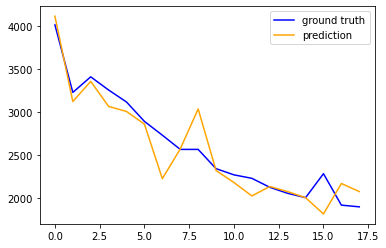

In [15]:
truth = raw_value[-test_size:].to_list()
plt.plot(truth, color = 'blue', label = "ground truth")
plt.plot(forecasts, color = 'orange', label = "prediction")
plt.legend()
plt.savefig("LSTM_demo.png", dpi=600)

# Perform on All countries, All Trials

In [16]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_step = 7  # step size

n_batch = 1
nb_epoch = 100
n_neurons = 1

In [17]:
# holder for metrics:
RMSE = []
MAE = []
MAPE = []

for country in countries:
    s = extract(df1, country)
    temp_RMSE = []
    temp_MAE = []
    temp_MAPE = []
    for j in range(0, len(df1)-(train_size+test_size+n_lag)+1, n_step):
        # prepare data
        raw_value = s[j:j+(train_size+test_size+n_lag)]
        # fit double layer lstm
        scaler, train, test = prepare_data(raw_value, diff, train_size, test_size, n_lag, n_seq)
        model = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
        forecasts = make_forecasts(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
        rmse_LSTM, mae_LSTM, mape_LSTM = evaluate_forecasts(raw_value[-test_size:], forecasts)

        temp_RMSE.append(rmse_LSTM)
        temp_MAE.append(mae_LSTM)
        temp_MAPE.append(mape_LSTM)
    
    RMSE.append(temp_RMSE)
    MAE.append(temp_MAE)
    MAPE.append(temp_MAPE)
    print(country)

Japan
Canada
Brazil
Argentina
Singapore
Italy
The United Kingdom


In [18]:
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    curr = {"rmse": temp_RMSE, "mae": temp_MAE, "mape": temp_MAPE}
    curr = pd.DataFrame(curr)
    curr.to_csv(country+"_double_lstm.csv", index = False)

In [19]:
curr

,rmse,mae,mape
0,99.319733,74.717933,1.617679
1,92.093896,78.807215,1.915562
2,141.365499,127.303147,3.601029
3,160.553352,145.554964,4.836551
4,89.224320,73.286282,3.086053
...,...,...,...
118,513.480154,415.076901,3.139015
119,340.449451,267.034463,3.209361
120,315.697454,275.678788,3.896128
121,685.333017,676.858606,13.454931


In [20]:
ave_rmse = []
ave_mae = []
ave_mape = []
for i in range(len(countries)):
    country = countries[i]
    temp_RMSE = RMSE[i]
    temp_MAE = MAE[i]
    temp_MAPE = MAPE[i]
    
    ave_rmse.append(np.mean(temp_RMSE))
    ave_mae.append(np.mean(temp_MAE))
    ave_mape.append(np.mean(temp_MAPE))

LSTM_db = {"country": countries, "rmse": ave_rmse, "mae": ave_mae, "mape": ave_mape}
LSTM_db = pd.DataFrame(LSTM_db)

In [21]:
LSTM_db

,country,rmse,mae,mape
0,Japan,1104.687383,882.132304,11.363024
1,Canada,237.726679,193.156288,4.198386
2,Brazil,2284.720806,1732.426993,4.932489
3,Argentina,715.146662,571.302275,6.406226
4,Singapore,143.662624,114.344061,7.804661
5,Italy,1246.708523,1071.191508,4.537425
6,The United Kingdom,1093.073628,916.927214,3.675396


In [22]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# alternative:
# scipy.stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

In [27]:
# import data
meanCI_rmse = []
meanCI_mae = []
meanCI_mape = []
for country in countries:
    df = pd.read_csv(country + '_double_lstm.csv', index_col = False)
    df.reset_index(drop=True, inplace=True)
    rmse = df[["rmse"]]
    mean_rmse, h_rmse = mean_confidence_interval(rmse, confidence=0.95)
    meanCI_rmse.append([mean_rmse, h_rmse])
    
    mae = df[["mae"]]
    mean_mae, h_mae = mean_confidence_interval(mae, confidence=0.95)
    meanCI_mae.append([mean_mae, h_mae])
    
    mape = df[["mape"]]
    mean_mape, h_mape = mean_confidence_interval(mape, confidence=0.95)
    meanCI_mape.append([mean_mape, h_mape])

In [28]:
meanCI_rmse

[[1104.687383042459, array([394.69575228])],
 [237.72667871987804, array([75.14320795])],
 [2284.720806103892, array([369.43191234])],
 [715.1466623351575, array([215.76931038])],
 [143.66262427223162, array([40.56877684])],
 [1246.7085229690326, array([371.94359614])],
 [1093.0736282604512, array([333.17812299])]]

In [29]:
meanCI_mae

[[882.1323036879929, array([312.30513796])],
 [193.15628830413786, array([63.14425779])],
 [1732.4269925115777, array([283.79371905])],
 [571.3022750379406, array([192.67478536])],
 [114.34406072472176, array([33.66741685])],
 [1071.1915082629366, array([329.96934593])],
 [916.9272143913364, array([279.80201972])]]

In [30]:
meanCI_mape

[[11.363023574576344, array([4.3706466])],
 [4.198386137282746, array([0.65619732])],
 [4.932489337170166, array([0.56107606])],
 [6.406226420156659, array([1.60511506])],
 [7.804660539510926, array([0.9163767])],
 [4.537425257816325, array([0.65176812])],
 [3.6753957673125144, array([0.58186242])]]